In [1]:
## importing stuff
import os
import pickle
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
import javabridge
from bioformats import JARS as bfJARS
javabridge.start_vm(class_path=bfJARS, max_heap_size="6G")
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# %aimport islets

from IPython.display import display
import pandas as pd

from islets.Recording import Recording, saveMovie
from islets.Regions import Regions
from islets.numeric import power_spectrum, rebin
from islets.utils import show_movie, saveRois
from islets.Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph

from caiman import movie as cmovie

from matplotlib.colors import LogNorm

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.



In [2]:
# from copy import deepcopy
fracSaturTh = .05
cmap = plt.cm.Greys
cmap.set_bad("lime")
pd.set_option('display.max_rows', 100)

In [3]:
# rec = Recording("/data/Sandra/2020/2020_06_24/Experiment56a.lif")
# rec = Recording("/data/MB2020_lifs/2012/2012_01_31/Pancreas_Islet_OGB13.lif")

In [3]:
# recs = [Recording("/data/Sandra/2020/2020_06_22/Series%03i.nd2"%i) for i in range(9,14)]

# for rec in recs:
#     display(rec.metadata)

In [4]:
rec = Recording("/data/Sandra/2020/2020_06_22/Series011.nd2")

In [5]:
ser = "all"

In [6]:
rec.import_series(ser)

In [7]:
metadata = rec.Series[ser]['metadata']

In [8]:
metadata

Name                                                               all
SizeT                                                            18487
SizeX                                                              256
SizeY                                                              256
pxSize                                                           0.829
pxUnit                                                              µm
bit depth                                                       uint16
Frequency                                                           19
Start time                                                         NaT
End time                                                           NaT
Duration                                        0 days 00:16:14.156120
individual Series                           Name  SizeT Start time ...
Name: 0, dtype: object

In [9]:
movie = cmovie(rec.Series[ser]['data'],fr = metadata.Frequency)

In [11]:
dmovie = np.diff(movie.astype(np.in16))

AttributeError: module 'numpy' has no attribute 'in16'

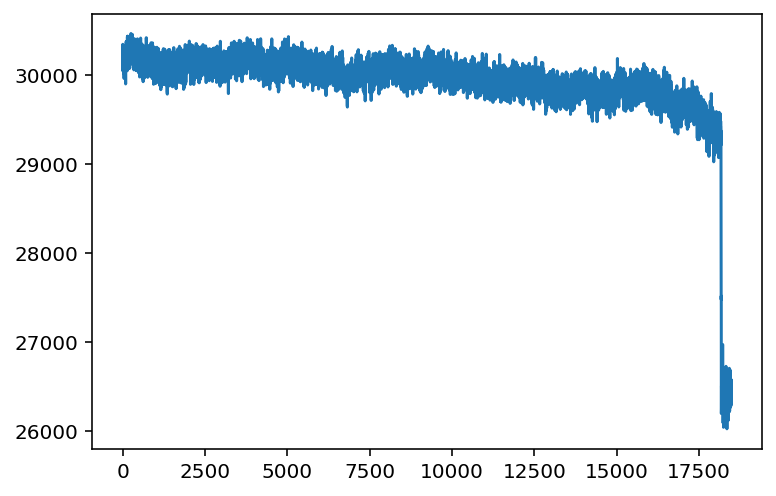

In [103]:
plt.plot(dmovie.mean((1,2)))

In [54]:
movie.shape

(18487, 256, 256)

In [55]:
movie.fr

19.0

In [56]:
meanImage = movie.mean(0)

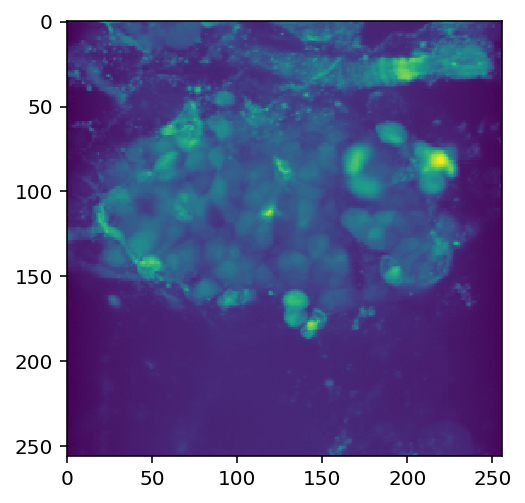

In [57]:
plt.imshow(meanImage, norm=LogNorm())

In [58]:
Nsatur = (movie==movie.max()).sum(0)

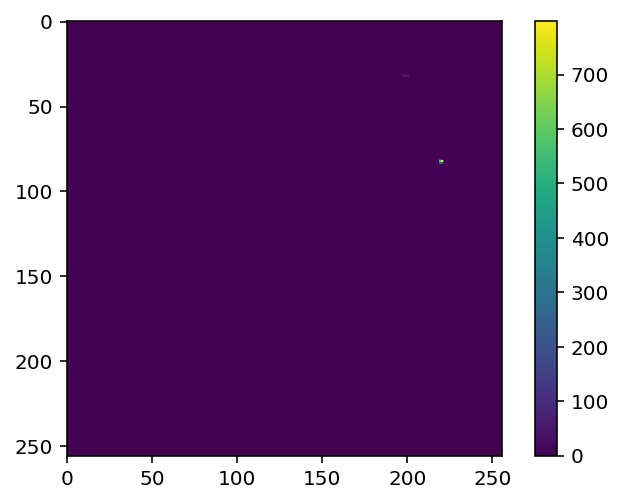

In [59]:
plt.imshow(Nsatur.astype(float),
#            norm=LogNorm()
          )
plt.colorbar()

In [60]:
plt.rcParams["animation.embed_limit"] = 200

In [12]:
# saveMovie(movie, "embed")

### Wiggles?

In [62]:
rwig = Regions(meanImage, gSig_filt=(3,))

In [64]:
freq = metadata["Frequency"]

In [65]:
n = 20
modFreq = []
for i in rwig.df.index:
    point = rwig.df.loc[i,"peak"]
    x = movie[:,point[0],point[1]]
    f,p = power_spectrum(x, fr=freq)
    f,p = f[f>1],np.abs(p[f>1])
    f = rebin(f,n)
    p = rebin(p,n)
    rwig.df.loc[i,"peakFreq"] = f[np.argmax(p)]
    rwig.df.loc[i,"peakProminence"] = np.max(p)

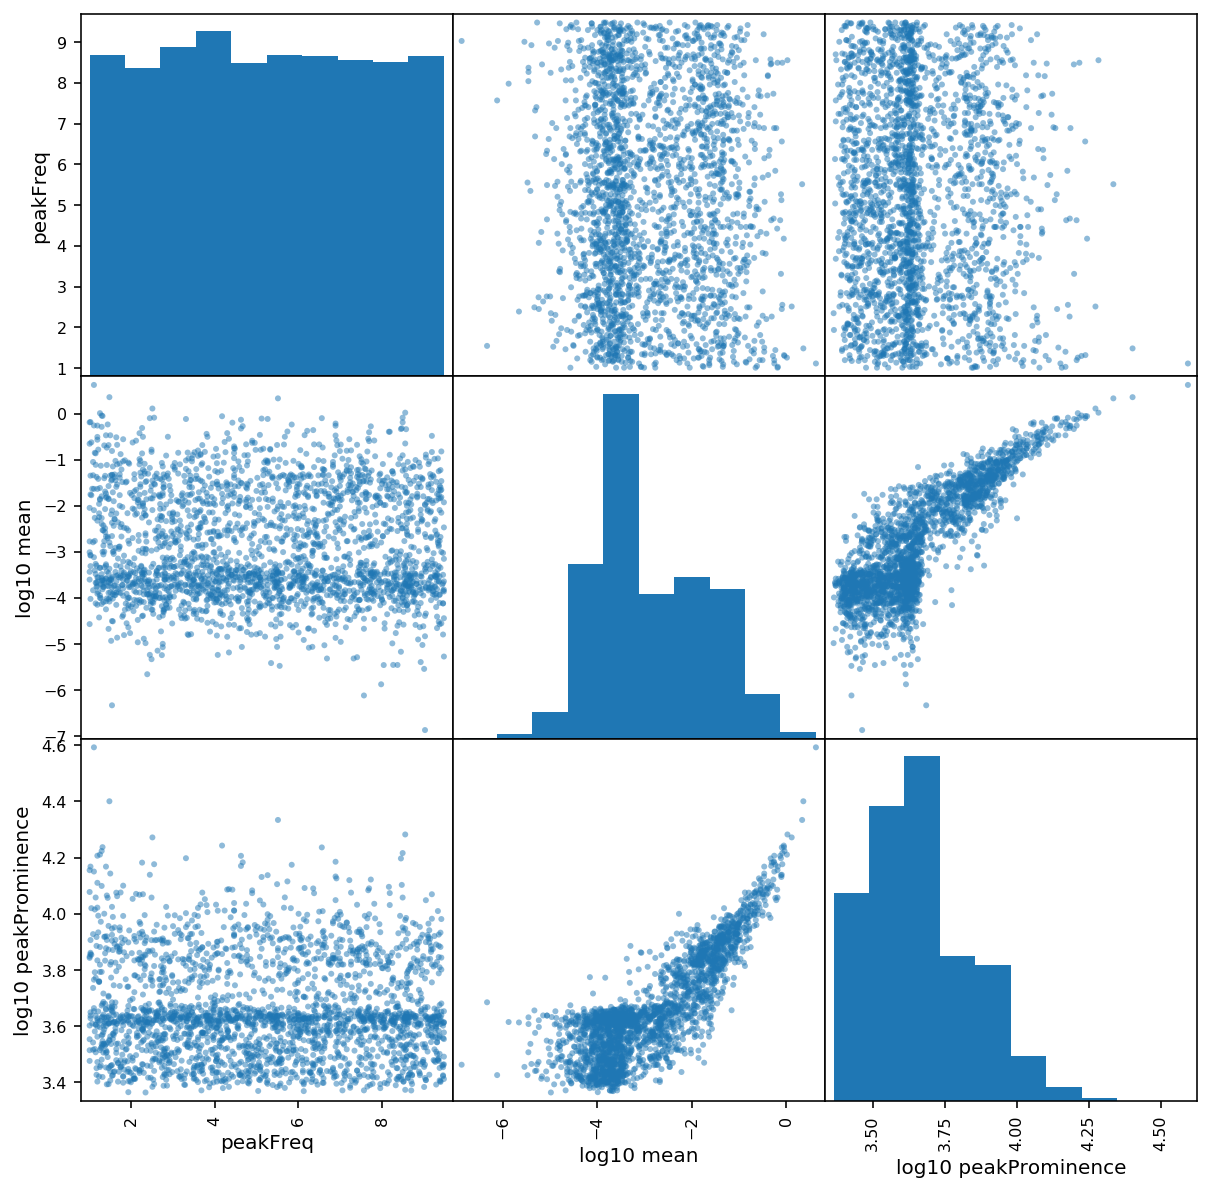

In [68]:
tmpdf = rwig.df[["peakValue","peakFreq","peakProminence"]].copy()
tmpdf["log10 mean"] = np.log10(tmpdf["peakValue"])
tmpdf["log10 peakProminence"] = np.log10(tmpdf["peakProminence"])
del tmpdf["peakProminence"], tmpdf["peakValue"]
pd.plotting.scatter_matrix(tmpdf, figsize=(10,10));

### import pickle

In [73]:
sorted(os.listdir(os.path.join(rec.path+"_analysis",ser)))

['.image_7.10.png',
 '.image_7.8.png',
 '.image_7.png',
 '.image_8.png',
 '7.10_rois.pkl',
 '7.8_rois.pkl',
 '7_rois.pkl',
 '8_rois.pkl',
 'Series011.nd2_all.mp4']

In [75]:
pickleFile = os.path.join(rec.path+"_analysis",ser,"8_rois.pkl")
with open(pickleFile,"rb") as f:
    regions = pickle.load(f)

In [77]:
regions.update()
regions.detrend_traces()

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

divide by zero encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdjan/srdjan_functs/islets/numeric.py:122: RuntimeWarning:

invalid value encountered in log

/home/jupyter-srdj

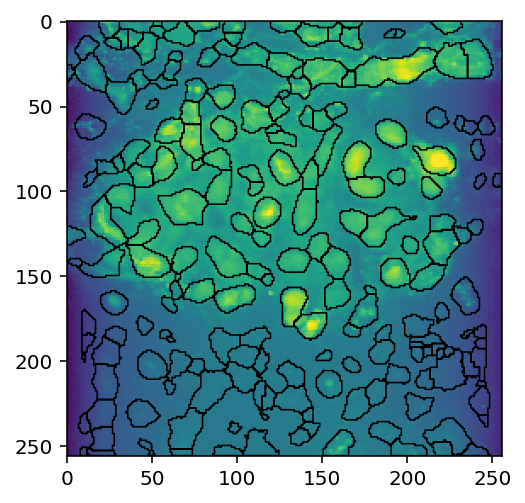

In [78]:
regions.plotEdges()

In [ ]:
regions.infer_gain(plot=True)

In [81]:
regions.gain

82.33755353054417

In [84]:
movie.shape, movie.dtype, movie.max()

((18487, 256, 256), dtype('uint16'), movie(4095, dtype=uint16))

In [89]:
# saveMovie(movie[:1000], "embed")

In [97]:
from islets.numeric import get_sep_th

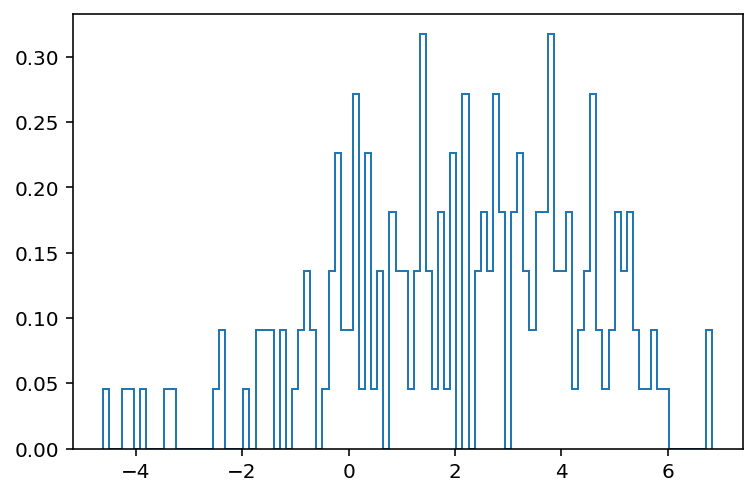

In [99]:
intTh = np.exp(get_sep_th(np.log(regions.df.interest), plot=True))

In [13]:
# show_movie(movie,
#            NTimeFrames=180,
#            additionalPlot=lambda ax_:regions.plotEdges(ax=ax_, image=False, color="navy",ix)
#           )

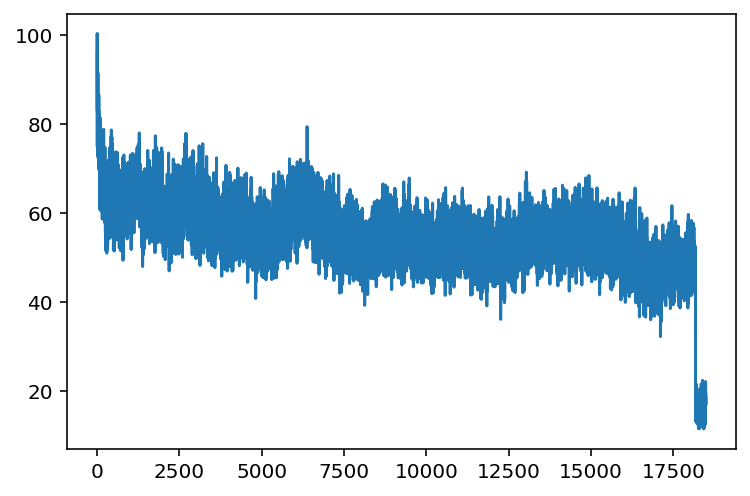

In [100]:
plt.plot(regions.df.trace[0])